# Import necessary packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.classification import LearningShapelets
from pyts.utils import windowed_view
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
np.int = np.int32
import networkx as nx

# Load single cell data

In [3]:
data = pd.read_csv("temporal_data_ready_normalized.csv", index_col=0)
# remove rows with NaN values
data = data.dropna(axis=0)

data

,d0,d1,d2,d5,d9,d15
gene_cell_type,,,,,,
A2M_B_cells,-0.254104,-0.230321,-0.280389,-0.263553,-0.251973,-0.011464
A2M_CD4_memory_T,0.060641,0.008146,-0.137329,-0.088526,-0.135368,-0.229559
A2M_CD4_memory_activated_T,-0.164474,-0.183414,-0.299799,-0.244234,-0.245678,-0.226539
A2M_CD4_naive_T,-0.212623,-0.236981,-0.299799,-0.192497,-0.299799,0.175611
A2M_CD8_naive_T,-0.233574,-0.238156,-0.299799,-0.299799,-0.299799,-0.299799
...,...,...,...,...,...,...
ZWINT_CIK_cells,-0.423474,-0.352725,-0.480251,-0.303389,-0.320375,-0.382367
ZWINT_Cycling_CD8_T,1.166380,0.331294,1.573891,0.908543,0.989413,0.899322
ZWINT_Cycling_CD8_memory_activated_T,1.427874,1.080232,2.436266,0.980481,1.059959,1.132355


In [6]:
# naive PCA on data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
data_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2"])
data_pca["label"] = data.index

# Plot PCA
sns.scatterplot(data=data_pca, x="PC1", y="PC2", hue="label")
plt.show()

ValueError: Image size of 384x349974 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [3]:
# generate the labels based on what's after the first underscore until the end in the row names
labels = data.index.str.extract(r'_(.*)$')
labels = labels[0].values

# associate each label with a unique integer
unique_labels = np.unique(labels)
label_dict = dict(zip(unique_labels, range(1, len(unique_labels) + 1)))
ylabels = np.array([label_dict[label] for label in labels])
ylabels

array([ 1,  2,  3, ...,  9, 10, 11])

In [27]:
# take first 2000 rows of both data and labels (takes about 10 seconds)
#X = data.values[:2000]
#y = ylabels[:2000]
X = data.values
y = ylabels

# create a LearningShapelets object
clf = LearningShapelets(random_state=42, tol=0.01, multi_class='ovr', n_jobs=32)

# fit the model
clf.fit(X, y)

LearningShapelets(multi_class='ovr', n_jobs=32, random_state=42, tol=0.01)

In [28]:
# merge the shapelets into a single list
shapelets = np.concatenate(clf.shapelets_)

shapelets_3 = [sub_arr for sub_arr in shapelets if len(sub_arr) >= 3]
shapelets_3 = np.array(shapelets_3)
shapelets_3

array([[-0.14131669, -0.12347606, -0.11797406],
       [ 0.7909326 ,  0.89273258,  0.77655762],
       [-0.14171683, -0.12394754, -0.11851092],
       [ 0.79691403,  0.89918164,  0.78226722],
       [-0.14166372, -0.12388498, -0.11843969],
       [ 0.79507268,  0.89719627,  0.78050945],
       [-0.14182247, -0.12407195, -0.11865255],
       [ 0.80475592,  0.90763681,  0.78975493],
       [-0.14166078, -0.12388151, -0.11843575],
       [ 0.79358668,  0.89559439,  0.77909126],
       [-0.1416202 , -0.1238337 , -0.11838131],
       [ 0.79205113,  0.89393863,  0.77762537],
       [-0.14161857, -0.12383179, -0.11837913],
       [ 0.79379525,  0.89581902,  0.77929011],
       [-0.14140317, -0.12357798, -0.11809012],
       [ 0.78877827,  0.89040983,  0.77450128],
       [-0.14136317, -0.12353084, -0.11803644],
       [ 0.78912797,  0.89078689,  0.7748351 ],
       [-0.14150049, -0.12369267, -0.11822072],
       [ 0.79251268,  0.89443626,  0.77806593],
       [-0.14164257, -0.12386006, -0.118

X_dist gives the distance from the two selected shapelets (still to understand how to get all shapelets)

In [30]:
shapelets_3.shape

(22, 3)

In [32]:
# Select two shapelets
#shapelets = np.asarray([clf.shapelets_[0, -1], clf.shapelets_[0, -2]])
shapelet_size = shapelets_3.shape[1]

X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean((X_window[:, :, None] - shapelets_3[None, :]) ** 2, axis=3).min(axis=1)
X_dist = pd.DataFrame(X_dist, columns=range(shapelets_3.shape[0]))

# update the index of the dataframe
#X_dist.index = data.index[:2000]
X_dist.index = data.index
X_dist

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
gene_cell_type,,,,,,,,,,,,,,,,,,,,,
A2M_B_cells,0.014266,1.014423,0.014231,1.026585,0.014236,1.022833,0.014222,1.042643,0.014236,1.019811,...,0.014240,1.020234,0.014258,1.010060,0.014262,1.010768,0.014250,1.017629,0.014238,1.018571
A2M_CD4_memory_T,0.000513,0.717003,0.000519,0.727234,0.000519,0.724076,0.000521,0.740759,0.000518,0.721534,...,0.000518,0.721890,0.000515,0.713336,0.000514,0.713931,0.000516,0.719699,0.000518,0.720491
A2M_CD4_memory_activated_T,0.012396,1.076478,0.012306,1.089049,0.012318,1.085171,0.012283,1.105642,0.012319,1.082047,...,0.012328,1.082485,0.012377,1.071969,0.012386,1.072700,0.012355,1.079792,0.012323,1.080766
A2M_CD4_naive_T,0.015265,0.916800,0.015158,0.928173,0.015172,0.924664,0.015129,0.943195,0.015173,0.921838,...,0.015184,0.922234,0.015242,0.912722,0.015252,0.913384,0.015216,0.919798,0.015177,0.920679
A2M_CD8_naive_T,0.018241,1.162355,0.018115,1.175436,0.018132,1.171401,0.018082,1.192698,0.018133,1.168150,...,0.018146,1.168606,0.018214,1.157661,0.018226,1.158422,0.018183,1.165803,0.018139,1.166817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT_CIK_cells,0.044980,1.337426,0.044781,1.351453,0.044807,1.347127,0.044728,1.369957,0.044809,1.343642,...,0.044830,1.344130,0.044937,1.332392,0.044957,1.333208,0.044889,1.341125,0.044818,1.342212
ZWINT_Cycling_CD8_T,1.125206,0.012750,1.126200,0.011435,1.126068,0.011832,1.126462,0.009821,1.126061,0.012157,...,1.125956,0.012111,1.125420,0.013242,1.125321,0.013161,1.125662,0.012395,1.126015,0.012292
ZWINT_Cycling_CD8_memory_activated_T,1.407423,0.063495,1.408542,0.060702,1.408394,0.061554,1.408838,0.057152,1.408386,0.062247,...,1.408268,0.062149,1.407665,0.064519,1.407553,0.064352,1.407937,0.062750,1.408335,0.062532


/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

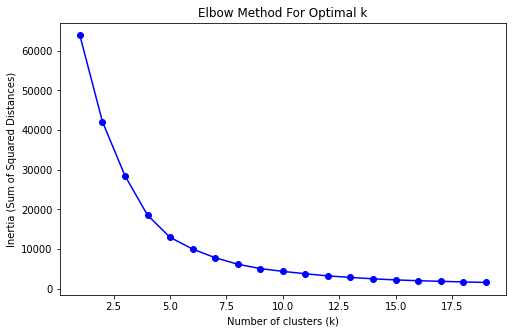

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for different numbers of clusters
inertia = []
K = range(1, 20)  # Try 1 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_dist)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [34]:
X_dist.columns = X_dist.columns.astype(str)

/home/collesei/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


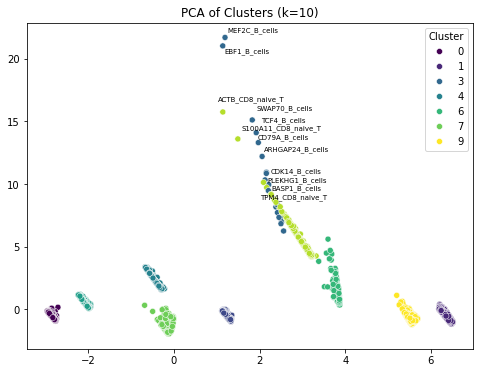

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_dist)

# Fit KMeans with optimal number of clusters (say, 3)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k)
X_dist['Cluster'] = kmeans.fit_predict(X_dist)

# Create a scatter plot with PCA results
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=X_dist['Cluster'], palette='viridis')

# Add index annotations to a few selected points (non-overlapping)
texts = []
for i in range(len(X_dist)):
    if np.abs(pca_result[i, 0]) > 10 or np.abs(pca_result[i, 1]) > 10:  # Consider points with PCA values greater than 2 as outliers
        texts.append(plt.text(pca_result[i, 0], pca_result[i, 1], str(X_dist.index[i]), fontsize=7))

# Adjust the text to avoid overlap
adjust_text(texts)

plt.title(f'PCA of Clusters (k={optimal_k})')
plt.show()


### Investigate MEF2C and EBF1 in B cells
First ping on google search (not too much effort)
https://pmc.ncbi.nlm.nih.gov/articles/PMC4762780/

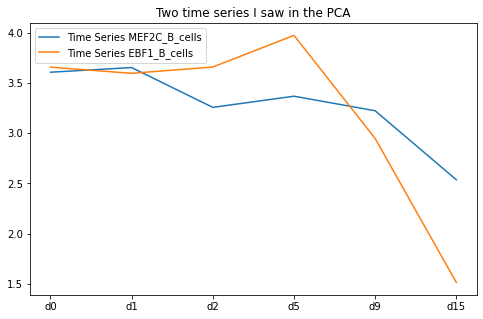

In [44]:
# Print two specific time series based on their index
index_0 = 'MEF2C_B_cells'
index_1 = 'EBF1_B_cells'

plt.figure(figsize=(8, 5))
plt.plot(data.loc[index_0], label=f'Time Series {index_0}')
plt.plot(data.loc[index_1], label=f'Time Series {index_1}')
plt.legend()
plt.title('Two time series I saw in the PCA')
plt.show()

In [38]:
X_dist_sorted = X_dist.sort_values(by='Cluster')
X_dist_sorted

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Cluster
gene_cell_type,,,,,,,,,,,,,,,,,,,,,
A2M_B_cells,0.014266,1.014423,0.014231,1.026585,0.014236,1.022833,0.014222,1.042643,0.014236,1.019811,...,1.020234,0.014258,1.010060,0.014262,1.010768,0.014250,1.017629,0.014238,1.018571,0
HELLPAR_CD4_naive_T,0.010552,1.099243,0.010464,1.111971,0.010475,1.108045,0.010440,1.128770,0.010476,1.104882,...,1.105325,0.010533,1.094677,0.010542,1.095417,0.010512,1.102598,0.010480,1.103584,0
HELLPAR_CD4_memory_T,0.006223,1.052752,0.006154,1.065211,0.006163,1.061367,0.006136,1.081657,0.006163,1.058271,...,1.058705,0.006208,1.048283,0.006215,1.049008,0.006191,1.056036,0.006167,1.057001,0
HEG1_CD4_naive_T,0.003446,1.004737,0.003398,1.016908,0.003404,1.013153,0.003386,1.032978,0.003405,1.010129,...,1.010553,0.003436,1.000371,0.003440,1.001079,0.003424,1.007945,0.003407,1.008888,0
HEG1_CD4_memory_T,0.013721,1.014584,0.013682,1.026748,0.013687,1.022996,0.013672,1.042808,0.013687,1.019973,...,1.020397,0.013712,1.010221,0.013716,1.010929,0.013703,1.017791,0.013689,1.018733,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TK1_Cycling_CD8_T,0.969444,0.058915,0.970152,0.056143,0.970058,0.056989,0.970339,0.052619,0.970053,0.057676,...,0.057579,0.969597,0.059932,0.969526,0.059766,0.969769,0.058176,0.970021,0.057959,9
TK1_Cycling_CD8_memory_activated_T,1.518153,0.125766,1.519274,0.122652,1.519125,0.123603,1.519569,0.118681,1.519117,0.124375,...,0.124267,1.518395,0.126905,1.518283,0.126720,1.518668,0.124936,1.519066,0.124694,9
TLE1_NK1,1.019234,0.173283,1.020111,0.173647,1.019995,0.173527,1.020342,0.174236,1.019988,0.173435,...,0.173448,1.019424,0.173169,1.019336,0.173187,1.019637,0.173372,1.019948,0.173399,9


In [45]:
# save to csv
X_dist_sorted.to_csv("shapelet_dist_clusters.csv")